In [78]:
%matplotlib inline
import time
import os
import numpy as np
from glob import glob
from skimage import io
from matplotlib import pyplot as plt
from helperfuncs import image_slice,imm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
from keras.models import load_model
from ast import literal_eval
import shutil
from skimage import morphology, measure

## Preprocessing for CNN 2 Development

In [2]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

In [4]:
image_files = glob(directory+'/small_sliced_images/*.png')
mask_files = glob(directory + '/small_sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

In [26]:
trainY_binary = to_categorical(trainY,2)

In [27]:
trainY_binary.shape

(2298, 64, 64, 2)

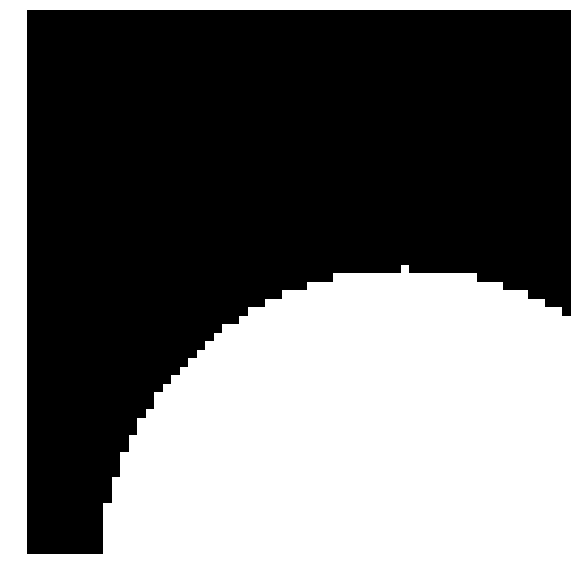

In [30]:
imm(trainY_binary[0,:,:,1].reshape([64,64]))

In [4]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(2298, 64, 64, 1) (2298, 64, 64, 1) (767, 64, 64, 1) (767, 64, 64, 1)


## CNN 2 Development

In [50]:
inputs = Input((64,64,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

# conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
# print("conv2 shape:",conv2.shape)
# conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
# print("conv2 shape:",conv2.shape)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# print("pool2 shape:",pool2.shape)

# conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
# print("conv3 shape:",conv3.shape)
# conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
# print("conv3 shape:",conv3.shape)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# print("pool3 shape:",pool3.shape)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv4 shape:",conv4.shape)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
print("conv4 shape:",conv4.shape)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
print("pool4 shape:",pool4.shape)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
print("conv5 shape:",conv5.shape)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
print("conv6 shape:",conv6.shape)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
# merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
print("up6 shape:",up6.shape)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
print("conv6 shape:",conv6.shape)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
print("conv6 shape:",conv6.shape)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
# merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
print("up7 shape:",up7.shape)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
print("conv7 shape:",conv7.shape)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
print("up8 shape:",up8.shape)
# merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
print("conv8 shape:",conv8.shape)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
# merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

conv1 shape: (?, 64, 64, 64)
conv1 shape: (?, 64, 64, 64)
pool1 shape: (?, 32, 32, 64)
conv4 shape: (?, 32, 32, 512)
conv4 shape: (?, 32, 32, 512)
pool4 shape: (?, 16, 16, 512)
conv5 shape: (?, 16, 16, 1024)
conv6 shape: (?, 32, 32, 512)
up6 shape: (?, 32, 32, 512)
conv6 shape: (?, 32, 32, 512)
conv6 shape: (?, 32, 32, 512)
up7 shape: (?, 64, 64, 256)
conv7 shape: (?, 16, 16, 256)
up8 shape: (?, 32, 32, 128)
conv8 shape: (?, 32, 32, 128)


/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(?, 64, 64, 1), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []

In [32]:
model.fit(trainX[:100],trainY[:100],batch_size=50,epochs=10,verbose=1,shuffle=True)

Epoch 1/10
100/100 [==============================] - 23s 234ms/step - loss: 0.6999 - acc: 0.5502
Epoch 2/10
100/100 [==============================] - 20s 202ms/step - loss: 0.6933 - acc: 0.6738
Epoch 3/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6931 - acc: 0.6766
Epoch 4/10
100/100 [==============================] - 20s 202ms/step - loss: 0.6930 - acc: 0.6793
Epoch 5/10
100/100 [==============================] - 20s 204ms/step - loss: 0.6930 - acc: 0.6795
Epoch 6/10
100/100 [==============================] - 20s 200ms/step - loss: 0.6930 - acc: 0.6795
Epoch 7/10
100/100 [==============================] - 20s 200ms/step - loss: 0.6929 - acc: 0.6795
Epoch 8/10
100/100 [==============================] - 20s 199ms/step - loss: 0.6929 - acc: 0.6795
Epoch 9/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6929 - acc: 0.6795
Epoch 10/10
100/100 [==============================] - 20s 199ms/step - loss: 0.6928 - acc: 0.6795


In [33]:
loss_and_metrics = model.evaluate(testX, testY, batch_size=12)

767/767 [==============================] - 43s 56ms/step


In [34]:
loss_and_metrics

[0.6928611940168806, 0.6447403780640026]

In [44]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 5s 55ms/step


In [45]:
np.any(np.isin([1],predicted_masks))

False

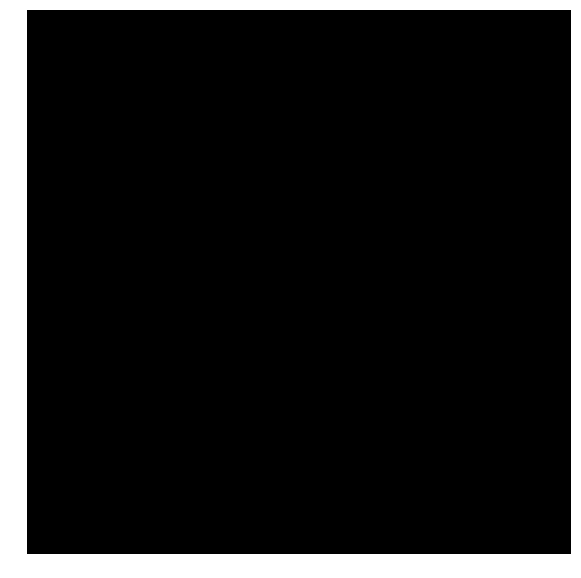

In [43]:
imm(predicted_masks[6,:,:,:].reshape([64,64]))

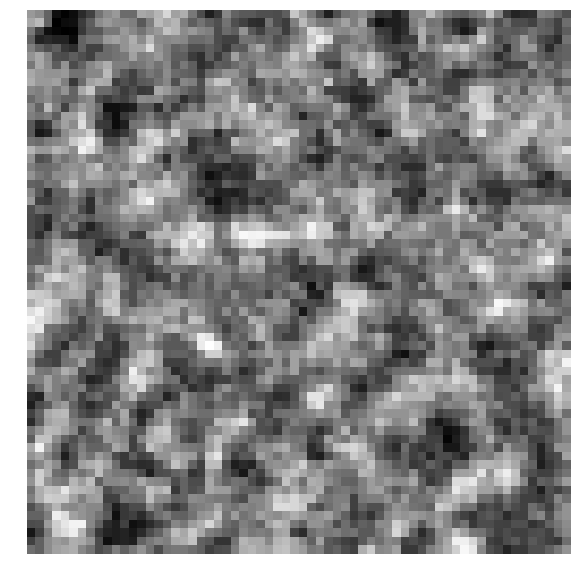

In [37]:
imm(testX[0,:,:,:].reshape([64,64]))

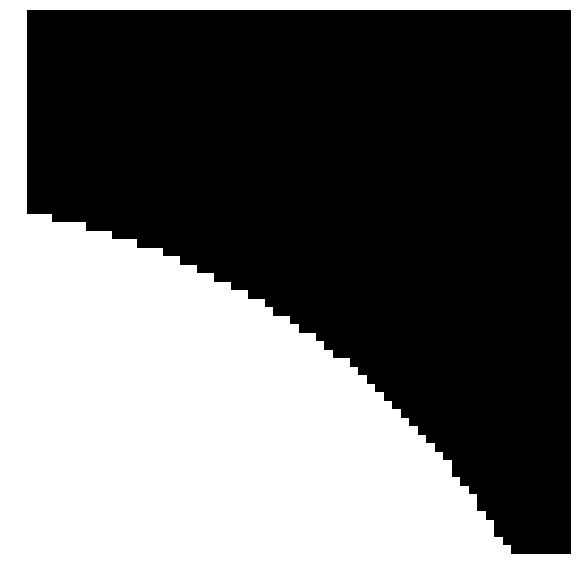

In [17]:
imm(testY[0,:,:,:].reshape([64,64]))

In [14]:
def reshape_for_viz(data_set,size,idx):
    img = data_set[idx,:,:,:].reshape(size)
    return img

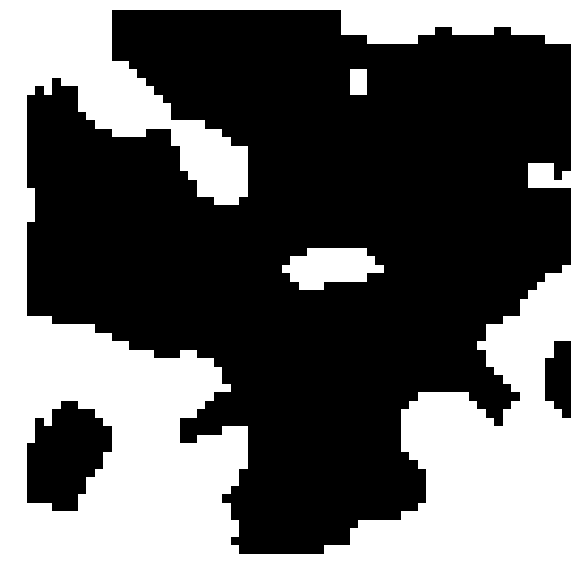

In [19]:
test_answer = reshape_for_viz(predicted_masks,(64,64),0)
test_answer[test_answer>0.35] = 1
test_answer[test_answer<=0.35] = 0
imm(test_answer)

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [8]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

In [9]:
def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [79]:
DATA_PATH = directory
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

BATCH_SIZE = 2

# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = int(len(trainY[:1000]) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)
model = get_unet_1024((64,64,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit(trainX[:1000],trainY[:1000],batch_size=50,epochs=10,verbose=1,shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_270 (Conv2D)             (None, 64, 64, 24)   240         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 64, 64, 24)   96          conv2d_270[0][0]                 
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 64, 64, 24)   0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_271

Epoch 1/10
1000/1000 [==============================] - 204s 204ms/step - loss: 1.2483 - dice_coef: 0.4663
Epoch 2/10
1000/1000 [==============================] - 194s 194ms/step - loss: 1.0428 - dice_coef: 0.5377
Epoch 3/10
1000/1000 [==============================] - 195s 195ms/step - loss: 0.8394 - dice_coef: 0.6232
Epoch 4/10
1000/1000 [==============================] - 194s 194ms/step - loss: 0.6760 - dice_coef: 0.6928
Epoch 5/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.5514 - dice_coef: 0.7481
Epoch 6/10
1000/1000 [==============================] - 195s 195ms/step - loss: 0.5147 - dice_coef: 0.7615
Epoch 7/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.4345 - dice_coef: 0.7975
Epoch 8/10
1000/1000 [==============================] - 196s 196ms/step - loss: 0.3954 - dice_coef: 0.8171
Epoch 9/10
1000/1000 [==============================] - 197s 197ms/step - loss: 0.3855 - dice_coef: 0.8210
Epoch 10/10
1000/1000 [==============

In [164]:
save_dir_pieces = directory.split('/')
save_dir = '/' +save_dir_pieces[0]
for idx, piece in enumerate(save_dir_pieces):
    if idx == 0:
        pass
    elif idx == len(save_dir_pieces)-1:
        pass
    else:
        save_dir += piece + '/'
       

save_dir

'/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/'

In [165]:
model_path = save_dir + 'models/second_trained_model_unet2.h5'

In [166]:
model.save(model_path)

In [167]:
model_path_weights = save_dir + 'models/second_trained_model_unet2_weights.h5'

In [168]:
model.save_weights(model_path_weights)

In [80]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 6s 61ms/step


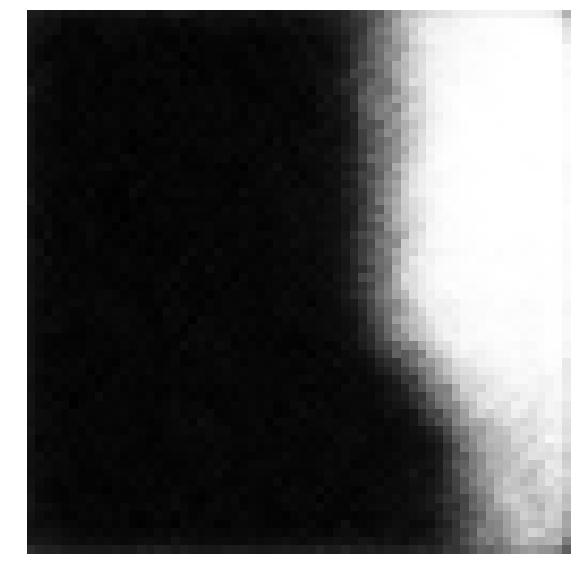

In [160]:
imm(predicted_masks[23,:,:,:].reshape([64,64]))

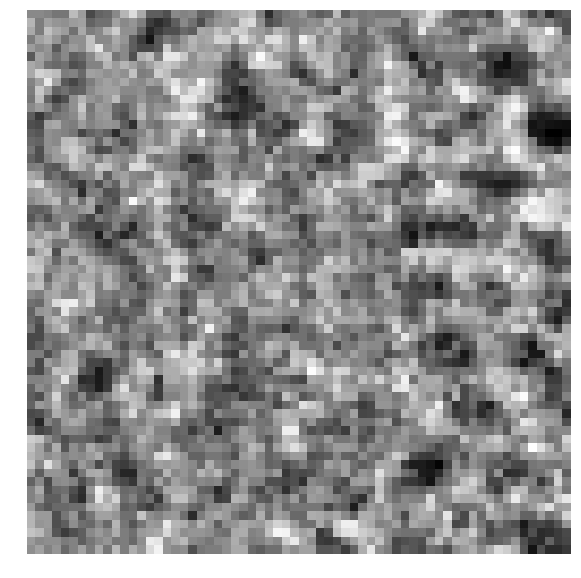

In [162]:
imm(testX[23,:,:,:].reshape([64,64]))

In [61]:
inputs = Input((64, 64, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

NameError: name 'smooth' is not defined

In [57]:
model.fit(trainX,trainY,batch_size=100,epochs=10,verbose=1,shuffle=True)

Epoch 1/10
1500/2298 [==================>...........] - ETA: 43s - loss: 0.6730 - acc: 0.6541

KeyboardInterrupt: 

In [7]:
model = load_model('models/second_trained_model_unet2.h5')

ValueError: Unknown loss function:bce_dice_loss

In [10]:
model = get_unet_1024((64,64,1))

In [11]:
model.load_weights('models/second_trained_model_unet2_weights.h5')

In [12]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 5s 52ms/step


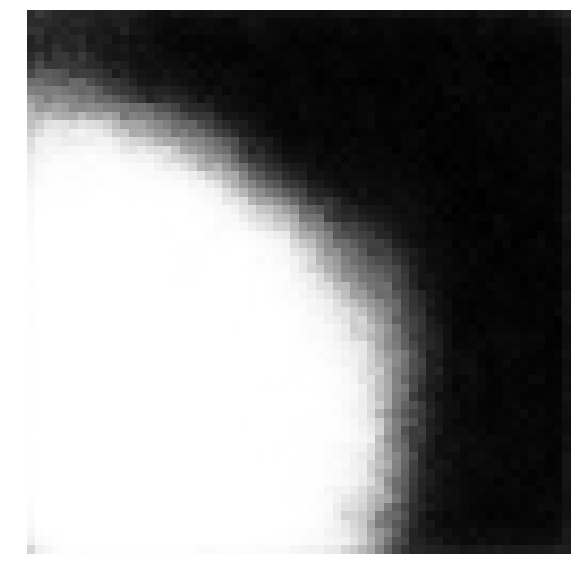

In [18]:
imm(predicted_masks[5,:,:,:].reshape([64,64]))

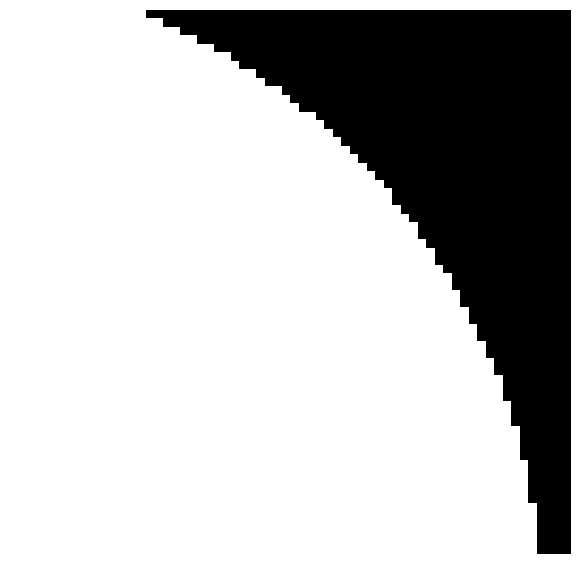

In [25]:
imm(testY[5,:,:,:].reshape([64,64]))

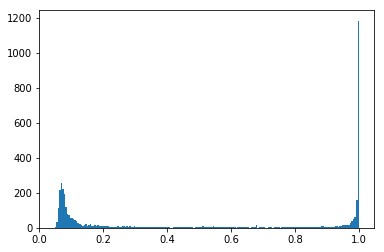

In [19]:
_ = plt.hist(predicted_masks[5,:,:,:].reshape([64,64]).flatten(),bins = 200)

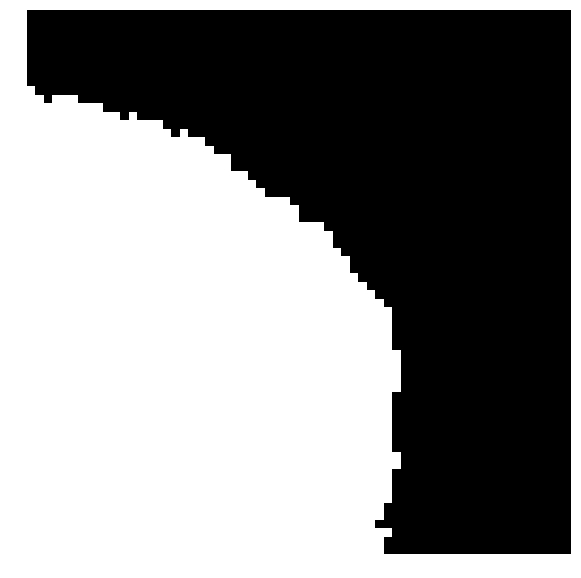

In [22]:
pred_mean = predicted_masks[5,:,:,:].reshape([64,64]).mean()
thres_img = predicted_masks[5,:,:,:].reshape([64,64])
thres_img[thres_img>pred_mean] = 1
thres_img[thres_img<= pred_mean] =0
imm(thres_img)

## CNN 2.5 : Using Larger Images (256x256)

In [2]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

image_files = glob(directory+'/med_sliced_images/*.png')
mask_files = glob(directory + '/med_sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

In [3]:
print(trainX.shape)

(532, 256, 256, 1)


In [7]:
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90.,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode = 'nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
batch_size = 2
# image_datagen.fit(trainX, augment=True, seed=seed)
# mask_datagen.fit(trainY, augment=True, seed=seed)

image_generator = image_datagen.flow(
    trainX,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

mask_generator = mask_datagen.flow(
    trainY,
    shuffle = True,
    batch_size = batch_size,
    seed=seed)
train_generator = zip(image_generator, mask_generator)

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

DATA_PATH = directory
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

BATCH_SIZE = 2

# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = int(len(trainY[:1000]) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)
model = get_unet_1024((256,256,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit_generator(train_generator,epochs=10,steps_per_epoch = steps_per_epoch,verbose=1,shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 256, 256, 24) 240         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 256, 256, 24) 96          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 256, 256, 24) 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_34 

Epoch 1/10
212/212 [==============================] - 737s 3s/step - loss: 1.2446 - dice_coef: 0.2616
Epoch 2/10
212/212 [==============================] - 726s 3s/step - loss: 1.0871 - dice_coef: 0.2823
Epoch 3/10
212/212 [==============================] - 727s 3s/step - loss: 1.0038 - dice_coef: 0.3328
Epoch 4/10
212/212 [==============================] - 728s 3s/step - loss: 0.9591 - dice_coef: 0.3511
Epoch 5/10
212/212 [==============================] - 728s 3s/step - loss: 0.9457 - dice_coef: 0.3610
Epoch 6/10
212/212 [==============================] - 728s 3s/step - loss: 0.9491 - dice_coef: 0.3571
Epoch 7/10
212/212 [==============================] - 728s 3s/step - loss: 0.8784 - dice_coef: 0.3990
Epoch 8/10
212/212 [==============================] - 728s 3s/step - loss: 0.8621 - dice_coef: 0.4245
Epoch 9/10
212/212 [==============================] - 728s 3s/step - loss: 1.0013 - dice_coef: 0.3161
Epoch 10/10
212/212 [==============================] - 728s 3s/step - loss: 0.9199

In [9]:
model.save('models/third_trained_model_unet2.5.h5')

## Model Build 2.6 - using more data

In [ ]:
def image_slice_medium(directory):
    """Used to break up the 1024x1024 images into 256x256 segments takes a
     diretory that is the source. This is only for creating training
     dataset. Throws out regions of the masks and images with no identified
     particles so that training set will have better balance of positive and
     negative pixels."""
    image_file_list = glob(directory+'/images2/*.png')
    image_new_directory = directory + '/med_sliced_images2/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    label_file_list = glob(directory+'/labels2/*.png')
    label_new_directory = directory + '/med_sliced_labels2/'
    if os.path.isdir(label_new_directory) != True:
        os.mkdir(label_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    label_name_list = [name.split('/')[-1].split('.')[0] for name in label_file_list]
    if len(image_name_list) != len(label_name_list):
        raise RuntimeError('different number of images and labels')
    if image_name_list != label_name_list:
        raise RuntimeError('images and labels did not match')
    for idx, file in enumerate(image_file_list):
        image2split = io.imread(file, as_grey=True)
        label2split = io.imread(label_file_list[idx], as_grey=True)
        for x in range(0,7*128,128):
            for y in range(0,7*128,128):
                image = image2split[x:x+256,y:y+256]
                label = label2split[x:x+256,y:y+256]
                if np.any(np.isin([1],label)) == False:
                    pass
                else:
                    image_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    label_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    plt.imsave(image_new_directory+image_name,image, cmap='gray')
                    plt.imsave(label_new_directory+label_name,label, cmap='gray')
    print('done!')

In [10]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

image_files = glob(directory+'/med_sliced_images2/*.png')
mask_files = glob(directory + '/med_sliced_labels2/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

print(trainX.shape)

(1347, 256, 256, 1)


In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

DATA_PATH = directory
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

BATCH_SIZE = 2

# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = int(len(trainY[:1000]) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)
model = get_unet_1024((256,256,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit(trainX[:1000], trainY[:1000],batch_size=10,epochs=5,verbose=1,shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 256, 256, 24) 240         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 256, 256, 24) 96          conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 256, 256, 24) 0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_66 

Epoch 1/5
1000/1000 [==============================] - 1476s 1s/step - loss: 1.0568 - dice_coef: 0.3134
Epoch 2/5
1000/1000 [==============================] - 1487s 1s/step - loss: 0.8168 - dice_coef: 0.4367
Epoch 3/5
1000/1000 [==============================] - 1471s 1s/step - loss: 0.7312 - dice_coef: 0.4899
Epoch 4/5
1000/1000 [==============================] - 1473s 1s/step - loss: 0.6780 - dice_coef: 0.5256
Epoch 5/5
1000/1000 [==============================] - 1474s 1s/step - loss: 0.6054 - dice_coef: 0.5724


In [12]:
predicted_masks = model.predict(testX[:100],batch_size=1,verbose=1)

100/100 [==============================] - 51s 511ms/step


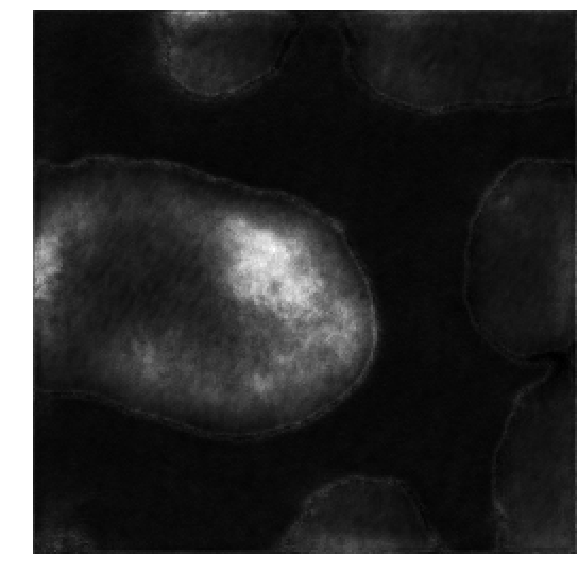

In [63]:
imm(predicted_masks[9,:,:,:].reshape([256,256]))

In [138]:
imm(testY[9,:,:,:].reshape([256,256]))

ValueError: cannot reshape array of size 4096 into shape (256,256)

In [53]:
loss_and_metrics = model.evaluate(testX, testY, batch_size=12)

450/450 [==============================] - 213s 474ms/step


In [55]:
loss_and_metrics

[0.8250481065114339, 0.40947442849477134]

In [54]:
model.save('models/fourth_trained_model_unet2.6.h5')
model.save_weights('models/third_trained_model_unet2.5_weights.h5')

In [57]:
model.fit(trainX, trainY,batch_size=10,epochs=6,verbose=1,shuffle=True)

Epoch 1/6
1347/1347 [==============================] - 2048s 2s/step - loss: 0.5906 - dice_coef: 0.5894
Epoch 2/6
1347/1347 [==============================] - 2049s 2s/step - loss: 0.5133 - dice_coef: 0.6400
Epoch 3/6
1347/1347 [==============================] - 2078s 2s/step - loss: 0.4483 - dice_coef: 0.6860
Epoch 4/6
1347/1347 [==============================] - 2050s 2s/step - loss: 0.3986 - dice_coef: 0.7214
Epoch 5/6
1347/1347 [==============================] - 2054s 2s/step - loss: 0.3741 - dice_coef: 0.7403
Epoch 6/6
1347/1347 [==============================] - 2049s 2s/step - loss: 0.3437 - dice_coef: 0.7624


In [58]:
loss_and_metrics = model.evaluate(testX, testY, batch_size=12)
loss_and_metrics

450/450 [==============================] - 223s 496ms/step


[0.7915756535530091, 0.5019704794883728]

## CNN 2.9 - 64x64 

In [66]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model


# Training new model

# num_epochs = 30
# steps_per_epoch = int(len(trainY[:1000]) * 0.8/BATCH_SIZE)

# model = get_unet_1024((64,64,1))
# model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
# print(model.summary())
# model.fit(trainX[:1000],trainY[:1000],batch_size=50,epochs=10,verbose=1,shuffle=True)

## Re-assembley 

In [77]:
from helperfuncs import slicing_for_assembley, reassemble_slices

In [78]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')
slicing_for_assembley(directory)

done!


In [79]:
directory = '/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/data_subset/'

In [80]:
image_files = glob(directory+'/small_sliced_images/*.png')
mask_files = glob(directory + '/small_sliced_labels/*.png')

asmblX = []
for file in image_files:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    asmblX.append(np.copy(img))
asmblX = np.asanyarray(asmblX)

asmblY = []
for file in mask_files:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    asmblY.append(np.copy(img))
asmblY = np.asanyarray(asmblY)

In [82]:
asmblX.shape

(768, 64, 64, 1)

In [72]:
model =  get_unet_1024((64,64,1))

In [73]:
model.load_weights('models/second_trained_model_unet2_weights.h5')

In [74]:
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])

In [81]:
loss_and_metrics = model.evaluate(asmblX, asmblY)
loss_and_metrics

768/768 [==============================] - 23s 30ms/step


[2.5578835358222327, 0.05997587220910342]

In [83]:
predicted_masks = model.predict(asmblX, verbose =1)

768/768 [==============================] - 24s 31ms/step


In [92]:
def reassemble_predicted_img(clean_masks):
    label_file_list = glob(directory+'/small_sliced_labels/*.png')
    label_file_list.append('end')
    previous_label = label_file_list[0].split('/')[-1].split('-')[0]
    previous_x = 'start'
#     previous_y = label_file_list[0].split('/')[-1].split('-')[2].split('.')[0]
    img_row = np.zeros((64,64))
    image = np.zeros((64,64))
    label_dict = {}
    for idx, label in enumerate(label_file_list):
        original_label = label.split('/')[-1].split('-')[0]
        if label != 'end':
            sub_img = clean_masks[idx,:,:].reshape([64,64])
            sub_x = label.split('/')[-1].split('-')[1]
            sub_y = label.split('/')[-1].split('-')[2].split('.')[0]
        if original_label == previous_label:
            if previous_x == 'start':
                img_row = sub_img
                previous_x = sub_x
            elif sub_x == str(0) and previous_x == sub_x:
                img_row = np.concatenate((img_row,sub_img),axis =1)
                previous_x = sub_x
            elif previous_x != sub_x and previous_x == str(0):
                image = img_row
                img_row = sub_img
                previous_x = sub_x
            elif sub_x != str(0) and previous_x == sub_x:
                img_row = np.concatenate((img_row,sub_img),axis =1)
                previous_x = sub_x
            elif previous_x != sub_x and previous_x != str(0) and previous_x != 'start':
                image = np.concatenate((image,img_row),axis =0)
                img_row = sub_img
                previous_x = sub_x
        else:
            image = np.concatenate((image,img_row),axis =0)
            label_dict[previous_label] = image
            previous_label = original_label
            image = np.zeros((64,64))
            img_row = sub_img
            previous_x = sub_x
        previous_label = original_label
    if os.path.isdir(directory+'/reconstructed_images') == False:
        new_directory = directory+'/reconstructed_images'
        os.mkdir(new_directory)
    else:
        new_directory = directory+'/reconstructed_images'
    for key in label_dict:
        plt.imsave(new_directory+'/'+key+'.png',label_dict[key],cmap = 'gray')
    print('done!')

In [177]:
prdt_mean = predicted_masks.mean()
clean_masks = []
for mask in predicted_masks:
    mask = mask.reshape([64,64]).copy()
    mask[mask > 0.95] = 1
    mask[mask <= 0.95] = 0
    mask = np.array(mask,dtype=int)
#     mask = segmentation.clear_border(mask)
    mask = morphology.dilation(morphology.dilation(morphology.erosion(morphology.closing(mask))))
    label_mask = measure.label(mask)
    mask = morphology.remove_small_objects(label_mask, min_size=1000)
#     morphology.remove_small_objects(mask, min_size=2000)
    clean_masks.append(mask)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [124]:
prdt_mean + predicted_masks.std()

0.9276717

In [178]:
clean_masks = np.asanyarray(clean_masks)

In [179]:
reassemble_predicted_img(clean_masks)

done!


In [97]:
from skimage import io
from skimage import exposure
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage import color

In [128]:
recon_files = glob(directory+'/reconstructed_images/*.png')

In [193]:
test_image = io.imread(recon_files[0],as_grey=True)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


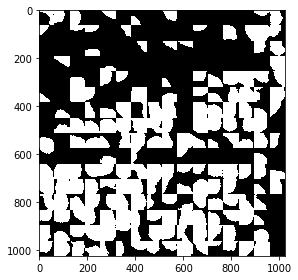

In [194]:
thresh = filters.threshold_otsu(test_image)
mask = test_image >= thresh
thresh_image = test_image.copy()
thresh_image[mask]=1
thresh_image[~mask]=0
io.imshow(thresh_image)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


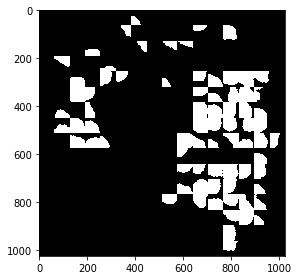

In [195]:
seg_image = segmentation.clear_border(thresh_image)
io.imshow(seg_image)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


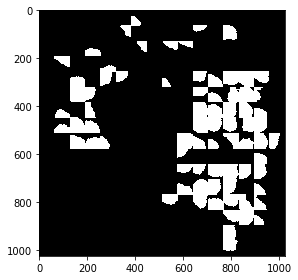

In [199]:
close_image= morphology.dilation(morphology.erosion(morphology.dilation(morphology.closing(seg_image))))
io.imshow(close_image)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


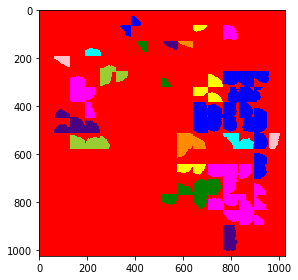

In [200]:
label_coins = measure.label(close_coins)
io.imshow(color.label2rgb(label_coins))
cleaned_coins = morphology.remove_small_objects(label_coins, min_size=900)
coin_regions = measure.regionprops(cleaned_coins)
prop_bbox = []
areas = []
eccentricities = []
for region in coin_regions:
    
    prop_bbox.append(region.bbox)
    areas.append(region.area)
    eccentricities.append(region.eccentricity)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


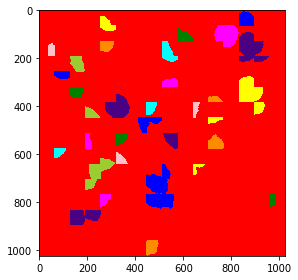

In [191]:
label_coins = measure.label(close_coins)
io.imshow(color.label2rgb(label_coins))
cleaned_coins = morphology.remove_small_objects(label_coins, min_size=900)
coin_regions = measure.regionprops(cleaned_coins)
prop_bbox = []
areas = []
eccentricities = []
for region in coin_regions:
    
    prop_bbox.append(region.bbox)
    areas.append(region.area)
    eccentricities.append(region.eccentricity)

In [117]:
import matplotlib.patches as patches

Text(0.5,1,'Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

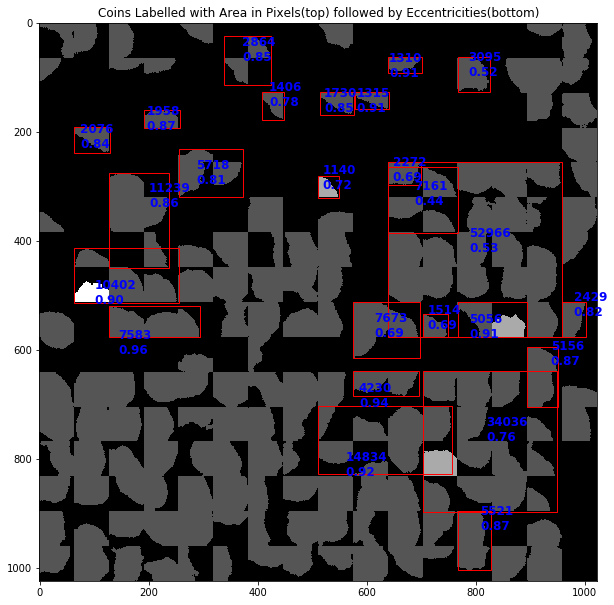

In [201]:
fig, ax = plt.subplots(1,figsize=(10,13))

ax.imshow(test_image, cmap='gray')
for idx, bbox in enumerate(prop_bbox):
    width = bbox[3]-bbox[1]
    height = bbox[2]-bbox[0]
    text = str(areas[idx])+'\n'+"{:0.2f}".format(eccentricities[idx])
    len_area = len(str(areas[idx]))
    ax.text(bbox[1]+(height//2)-12,bbox[0]+(width//2)+len_area,text,size = 'large',color='blue',weight = 'semibold')
    rect = patches.Rectangle((bbox[1],bbox[0]),width,height,fill=None,edgecolor = 'red')
    ax.add_patch(rect)
ax.set_title('Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

## Last Ditch

In [7]:
def image_slice_medium(directory):
    """Used to break up the 1024x1024 images into 256x256 segments takes a
     diretory that is the source. This is only for creating training
     dataset. Throws out regions of the masks and images with no identified
     particles so that training set will have better balance of positive and
     negative pixels."""
    image_file_list = glob(directory+'/images2/*.png')
    image_new_directory = directory + '/med_sliced_images/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    label_file_list = glob(directory+'/labels2/*.png')
    label_new_directory = directory + '/med_sliced_labels/'
    if os.path.isdir(label_new_directory) != True:
        os.mkdir(label_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    label_name_list = [name.split('/')[-1].split('.')[0] for name in label_file_list]
    if len(image_name_list) != len(label_name_list):
        raise RuntimeError('different number of images and labels')
    if image_name_list != label_name_list:
        raise RuntimeError('images and labels did not match')
    for idx, file in enumerate(image_file_list):
        image2split = io.imread(file, as_grey=True)
        label2split = io.imread(label_file_list[idx], as_grey=True)
        for x in range(0,4*256,256):
            for y in range(0,4*256,256):
                image = image2split[x:x+256,y:y+256]
                label = label2split[x:x+256,y:y+256]
                if np.any(np.isin([1],label)) == False:
                    pass
                else:
                    image_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    label_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    plt.imsave(image_new_directory+image_name,image, cmap='gray')
                    plt.imsave(label_new_directory+label_name,label, cmap='gray')
    print('done!')

In [9]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')
image_slice_medium(directory)
image_files = glob(directory+'/med_sliced_images/*.png')
mask_files = glob(directory + '/med_sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

print(trainX.shape)

done!
(1347, 256, 256, 1)


In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model


In [10]:
model = get_unet_1024((256,256,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit(trainX, trainY,batch_size=10,epochs=20,verbose=1,shuffle=True)
loss_and_metrics = model.evaluate(testX, testY)
print('loss: {} dice_coef: {}'.format(loss_and_metrics))
model.save('models/fourth_trained_model_unet2.6.h5')
model.save_weights('models/fourth_trained_model_unet2.6_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 256, 256, 24) 240         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 256, 256, 24) 96          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 256, 256, 24) 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_34 

Epoch 1/20
1347/1347 [==============================] - 2051s 2s/step - loss: 1.0934 - dice_coef: 0.3022
Epoch 2/20
1347/1347 [==============================] - 2043s 2s/step - loss: 0.8680 - dice_coef: 0.4069
Epoch 3/20
1347/1347 [==============================] - 2044s 2s/step - loss: 0.7973 - dice_coef: 0.4495
Epoch 4/20
1347/1347 [==============================] - 2043s 2s/step - loss: 0.7257 - dice_coef: 0.4943
Epoch 5/20
1347/1347 [==============================] - 2069s 2s/step - loss: 0.6458 - dice_coef: 0.5452
Epoch 6/20
1347/1347 [==============================] - 2047s 2s/step - loss: 0.5683 - dice_coef: 0.5964
Epoch 7/20
1347/1347 [==============================] - 2045s 2s/step - loss: 0.5135 - dice_coef: 0.6341
Epoch 8/20
1347/1347 [==============================] - 2047s 2s/step - loss: 0.4615 - dice_coef: 0.6708
Epoch 9/20
1347/1347 [==============================] - 2046s 2s/step - loss: 0.4151 - dice_coef: 0.7026
Epoch 10/20
1347/1347 [==============================] 

IndexError: tuple index out of range

In [12]:
model.save('models/fourth_trained_model_unet2.6.h5')
model.save_weights('models/fourth_trained_model_unet2.6_weights.h5')

In [15]:
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=180.,
                     horizontal_flip=True,
                     fill_mode = 'nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
batch_size = 10
# image_datagen.fit(trainX, augment=True, seed=seed)
# mask_datagen.fit(trainY, augment=True, seed=seed)

image_generator = image_datagen.flow(
    trainX,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

mask_generator = mask_datagen.flow(
    trainY,
    shuffle = True,
    batch_size = batch_size,
    seed=seed)
train_generator = zip(image_generator, mask_generator)

In [20]:
image_test_datagen = ImageDataGenerator(rescale = 1.)
mask_test_datagen = ImageDataGenerator(rescale = 1.)
image_validation_generator = image_test_datagen.flow(testX, batch_size=batch_size)
mask_validation_generator = mask_test_datagen.flow(testY, batch_size=batch_size)
validation_generator = zip(image_validation_generator, mask_validation_generator)

In [21]:
steps_per_epoch = 134
model = get_unet_1024((256,256,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit_generator(train_generator,epochs=10, steps_per_epoch= steps_per_epoch,verbose=1,shuffle=True, validation_data=validation_generator, validation_steps=50)
model.save('models/fifth_trained_model_unet2.65.h5')
model.save_weights('models/fifth_trained_model_unet2.65_weights.h5')
loss_and_metrics = model.evaluate(testX, testY)
print('loss: {} dice_coef: {}'.format(loss_and_metrics[0], loss_and_metrics[1]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 256, 256, 24) 240         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 256, 256, 24) 96          conv2d_161[0][0]                 
__________________________________________________________________________________________________
activation_161 (Activation)     (None, 256, 256, 24) 0           batch_normalization_161[0][0]    
__________________________________________________________________________________________________
conv2d_162

Epoch 1/10
134/134 [==============================] - 2318s 17s/step - loss: 1.1739 - dice_coef: 0.2802 - val_loss: 3.9305 - val_dice_coef: 0.1803
Epoch 2/10
134/134 [==============================] - 2291s 17s/step - loss: 0.9761 - dice_coef: 0.3541 - val_loss: 3.3462 - val_dice_coef: 0.1743
Epoch 3/10
134/134 [==============================] - 2314s 17s/step - loss: 0.9328 - dice_coef: 0.3727 - val_loss: 1.4479 - val_dice_coef: 0.1469
Epoch 4/10
134/134 [==============================] - 2289s 17s/step - loss: 0.8989 - dice_coef: 0.3865 - val_loss: 1.5671 - val_dice_coef: 0.1538
Epoch 5/10
134/134 [==============================] - 2289s 17s/step - loss: 0.8589 - dice_coef: 0.4111 - val_loss: 1.5733 - val_dice_coef: 0.1529
Epoch 6/10
107/134 [======================>.......] - ETA: 6:53 - loss: 0.8341 - dice_coef: 0.4230

KeyboardInterrupt: 

In [205]:
def image_slice_med_sliding(directory):
    """Used to break up the 1024x1024 images into 256x256 segments takes a
     diretory that is the source. This is only for creating training
     dataset. Throws out regions of the masks and images with no identified
     particles so that training set will have better balance of positive and
     negative pixels."""
    image_file_list = glob(directory+'/images2/*.png')
    image_new_directory = directory + '/med_sliced_images2/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    label_file_list = glob(directory+'/labels2/*.png')
    label_new_directory = directory + '/med_sliced_labels2/'
    if os.path.isdir(label_new_directory) != True:
        os.mkdir(label_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    label_name_list = [name.split('/')[-1].split('.')[0] for name in label_file_list]
    if len(image_name_list) != len(label_name_list):
        raise RuntimeError('different number of images and labels')
    if image_name_list != label_name_list:
        raise RuntimeError('images and labels did not match')
    for idx, file in enumerate(image_file_list):
        image2split = io.imread(file, as_grey=True)
        label2split = io.imread(label_file_list[idx], as_grey=True)
        for x in range(0,7*128,128):
            for y in range(0,7*128,128):
                image = image2split[x:x+256,y:y+256]
                label = label2split[x:x+256,y:y+256]
                if np.any(np.isin([1],label)) == False:
                    pass
                else:
                    image_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    label_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    plt.imsave(image_new_directory+image_name,image, cmap='gray')
                    plt.imsave(label_new_directory+label_name,label, cmap='gray')
    print('done!')


In [ ]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')
image_slice_med_sliding(directory)
image_files = glob(directory+'/med_sliding_images/*.png')
mask_files = glob(directory + '/med_sliding_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

print(trainX.shape)

In [23]:
testX[0,:,:,:].max()

1.0

In [24]:
trainX[0,:,:,:].max()

1.0

In [25]:
trainY[0,:,:,:].max()

1.0

In [26]:
def image_slice_small(directory):
    """Used to break up the 1024x1024 images into 64x64 segments takes a
     diretory that is the source. This is only for creating training
     dataset. Throws out regions of the masks and images with no identified
     particles so that training set will have better balance of positive and
     negative pixels."""
    image_file_list = glob(directory+'/images/*.png')
    image_new_directory = directory + '/small_sliced_images/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    label_file_list = glob(directory+'/labels/*.png')
    label_new_directory = directory + '/small_sliced_labels/'
    if os.path.isdir(label_new_directory) != True:
        os.mkdir(label_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    label_name_list = [name.split('/')[-1].split('.')[0] for name in label_file_list]
    if len(image_name_list) != len(label_name_list):
        raise RuntimeError('different number of images and labels')
    if image_name_list != label_name_list:
        raise RuntimeError('images and labels did not match')
    for idx, file in enumerate(image_file_list):
        image2split = io.imread(file, as_grey=True)
        label2split = io.imread(label_file_list[idx], as_grey=True)
        for x in range(0,15*64,64):
            for y in range(0,15*64,64):
                image = image2split[x:x+64,y:y+64]
                label = label2split[x:x+64,y:y+64]
                if np.any(np.isin([1],label)) == False:
                    pass
                else:
                    image_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    label_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    plt.imsave(image_new_directory+image_name,image, cmap='gray')
                    plt.imsave(label_new_directory+label_name,label, cmap='gray')
    print('done!')


In [32]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')
image_slice_small(directory)
image_files = glob(directory+'/small_sliced_images/*.png')
mask_files = glob(directory + '/small_sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append((np.copy(img)-img.mean()))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append((np.copy(img)-img.mean()))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

print(trainX.shape)

done!
(2298, 64, 64, 1)


In [34]:
valX = testX[:500]
valY = testY[:500]
testX = testX[500:]
testY = testY[500:]

In [35]:
model = get_unet_1024((64,64,1))
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
model.fit(trainX, trainY,batch_size=10,epochs=10,verbose=1,shuffle=True, validation_data=(valX,valY))
model.save('models/fifth_trained_model_unet3.h5')
model.save_weights('models/fifth_trained_model_unet3_weights.h5')
loss_and_metrics = model.evaluate(testX, testY)
print('loss: {} dice_coef: {}'.format(loss_and_metrics[0],loss_and_metrics[1]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 64, 64, 24)   240         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 64, 64, 24)   96          conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation_193 (Activation)     (None, 64, 64, 24)   0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194

Train on 2298 samples, validate on 500 samples
Epoch 1/10
2298/2298 [==============================] - 527s 229ms/step - loss: 1.1455 - dice_coef: 0.4751 - val_loss: 1.7742 - val_dice_coef: 0.5969
Epoch 2/10
2298/2298 [==============================] - 519s 226ms/step - loss: 1.0196 - dice_coef: 0.5381 - val_loss: 1.9088 - val_dice_coef: 0.5807
Epoch 3/10
2298/2298 [==============================] - 518s 226ms/step - loss: 0.9284 - dice_coef: 0.5853 - val_loss: 0.9337 - val_dice_coef: 0.6108
Epoch 4/10
2298/2298 [==============================] - 518s 225ms/step - loss: 0.8406 - dice_coef: 0.6271 - val_loss: 4.3678 - val_dice_coef: 0.5339
Epoch 5/10
2298/2298 [==============================] - 516s 224ms/step - loss: 0.7334 - dice_coef: 0.6733 - val_loss: 1.3011 - val_dice_coef: 0.4461
Epoch 6/10
2298/2298 [==============================] - 512s 223ms/step - loss: 0.6231 - dice_coef: 0.7278 - val_loss: 1.1713 - val_dice_coef: 0.5485
Epoch 7/10
2298/2298 [==============================]

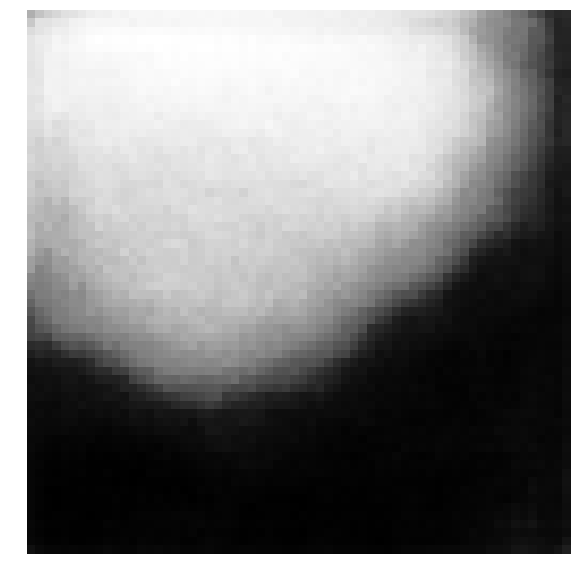

In [40]:
t3 = model.predict(testX)
imm(t3[1,:,:,:].reshape((64,64)))

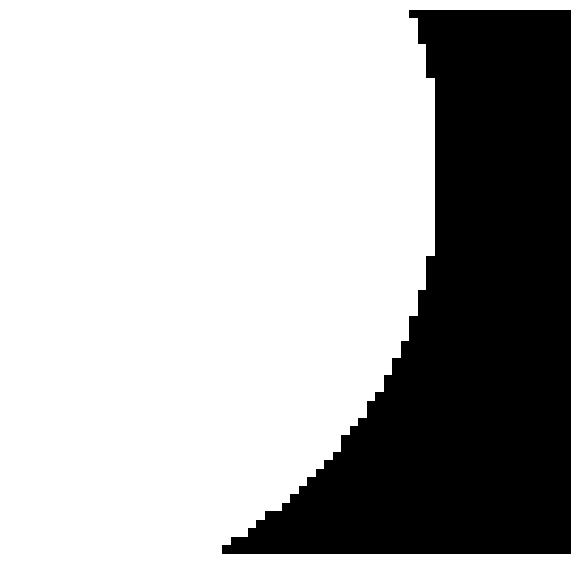

In [43]:
imm(testY[1,:,:,:].reshape(64,64))

## Creating Segmented Data 

In [44]:
directory

'/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/data'

In [47]:
# make labels for fresh data
def txt_reader(file):
    txt_info = open(file,'r')
    txt = []
    centers = []
    radii = []
    for line in txt_info:
        if line == '\n':
            pass
        else:
            line = line.strip('\n')
            txt.append(line)
    center_stop = txt.index('Radius Size:')
    radius_stop = txt.index('Defect Label:')
    for loc in txt[1:center_stop]:
        centers.append(literal_eval(loc))
    for loc in txt[center_stop+1:radius_stop] :
        radii.append(int(loc))
    image_size = literal_eval(txt[-1])
    return centers, radii, image_size


def spot_maker(location, radius, label_mask):
    for x in np.arange(location[0]-radius,location[0]+radius,1):
        for y in np.arange(location[1]-radius,location[1]+radius,1):
            dx = x - location[0]
            dy = y - location[1]
            if np.sqrt((dx**2+dy**2)) <= radius \
            and int(x) < label_mask.shape[0] and int(y) < label_mask.shape[1]:
                label_mask[int(y),int(x)] = 1
    return label_mask

def mask_maker(file):
    centers, radii, image_size = txt_reader(file)
    label_mask = np.zeros(image_size)
    for idx,radius in enumerate(radii):
        label_mask = spot_maker(centers[idx],radius,label_mask)
    return label_mask

def mask_pipeline(directory):
    if os.path.isdir(directory+'/text_files') == True:
        file_list = glob(directory+'/text_files/*.txt')
    else:
        raise RuntimeError('no text_files directory found')
    name_list = [name.split('/')[-1].split('.')[0] for name in file_list]
    if os.path.isdir(directory+'/labels') != True:
        os.mkdir(directory+'/labels')
    if os.path.isdir(directory+'/old_text_files') != True:
        os.mkdir(directory+'/old_text_files')
    for idx, file in enumerate(file_list):
        if len(open(file,'r').readlines()) == 0:
            pass
        else:
            label_mask = mask_maker(file)
            plt.imsave(directory+'/labels/'+name_list[idx]+'.png',label_mask, cmap='gray')
        shutil.move(file,directory+'/old_text_files/')
    print('done!')

mask_pipeline(directory)

done!


In [49]:
from helperfuncs import slicing_for_assembley
#slicing for assembley
slicing_for_assembley(directory)

done!


In [50]:
image_files = glob(directory+'/small_sliced_images_asmbl/*.png')
mask_files = glob(directory + '/small_sliced_labels_asmbl/*.png')

asmblX = []
for file in image_files:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    asmblX.append(np.copy(img))
asmblX = np.asanyarray(asmblX)

asmblY = []
for file in mask_files:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    asmblY.append(np.copy(img))
asmblY = np.asanyarray(asmblY)

In [51]:
predicted_masks = model.predict(asmblX, verbose =1)

66304/66304 [==============================] - 2055s 31ms/step


In [86]:
def reassemble_predicted_img(clean_masks):
    label_file_list = glob(directory+'/small_sliced_labels_asmbl/*.png')
    label_file_list.append('end')
    previous_label = label_file_list[0].split('/')[-1].split('-')[0]
    previous_x = 'start'
#     previous_y = label_file_list[0].split('/')[-1].split('-')[2].split('.')[0]
    img_row = np.zeros((64,64))
    image = np.zeros((64,64))
    label_dict = {}
    sub_img = clean_masks[0,:,:].reshape([64,64])
    sub_x = 0
    sub_y = 0
    for idx, label in enumerate(label_file_list):
        original_label = label.split('/')[-1].split('-')[0]
        if label != 'end':
            sub_img = clean_masks[idx,:,:].reshape([64,64])
            sub_x = label.split('/')[-1].split('-')[1]
            sub_y = label.split('/')[-1].split('-')[2].split('.')[0]
        if original_label == previous_label:
            if previous_x == 'start':
                img_row = sub_img
                previous_x = sub_x
            elif sub_x == str(0) and previous_x == sub_x:
                img_row = np.concatenate((img_row,sub_img),axis =1)
                previous_x = sub_x
            elif previous_x != sub_x and previous_x == str(0):
                image = img_row
                img_row = sub_img
                previous_x = sub_x
            elif sub_x != str(0) and previous_x == sub_x:
                img_row = np.concatenate((img_row,sub_img),axis =1)
                previous_x = sub_x
            elif previous_x != sub_x and previous_x != str(0) and previous_x != 'start':
                image = np.concatenate((image,img_row),axis =0)
                img_row = sub_img
                previous_x = sub_x
        else:
            image = np.concatenate((image,img_row),axis =0)
            label_dict[previous_label] = image
            previous_label = original_label
            image = np.zeros((64,64))
            img_row = sub_img
            previous_x = sub_x
        previous_label = original_label
    if os.path.isdir(directory+'/reconstructed_images') == False:
        new_directory = directory+'/reconstructed_images'
        os.mkdir(new_directory)
    else:
        new_directory = directory+'/reconstructed_images'
    for key in label_dict:
        plt.imsave(new_directory+'/'+key+'.png',label_dict[key],cmap = 'gray')
    print('done!')

In [79]:
prdt_mean = predicted_masks.mean()
clean_masks = []
for mask in predicted_masks:
    mask = mask.reshape([64,64]).copy()
    mask[mask > 0.95] = 1
    mask[mask <= 0.95] = 0
    mask = np.array(mask,dtype=int)
#     mask = segmentation.clear_border(mask)
    mask = morphology.dilation(morphology.dilation(morphology.erosion(morphology.closing(mask))))
    label_mask = measure.label(mask)
    mask = morphology.remove_small_objects(label_mask, min_size=1000)
#     morphology.remove_small_objects(mask, min_size=2000)
    clean_masks.append(mask)
clean_masks = np.asanyarray(clean_masks)

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [87]:
reassemble_predicted_img(clean_masks)

done!


In [54]:
predicted_masks.mean() + predicted_masks.std()

1.0418068

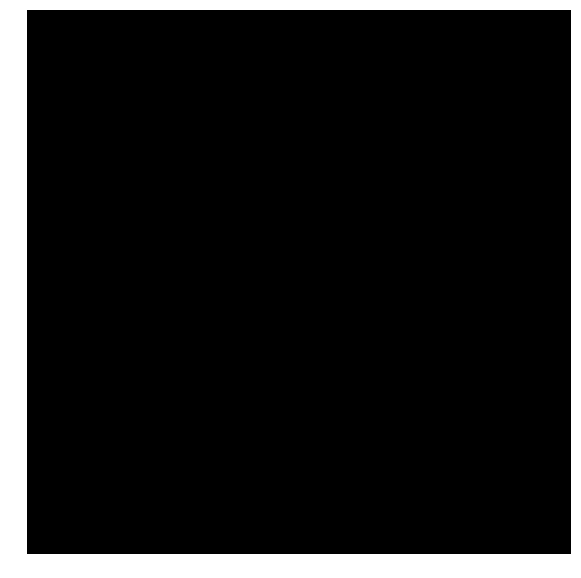

In [69]:
imm(asmblY[3,:,:,:].reshape(64,64))

In [72]:
loss_and_metrics = model.evaluate(asmblX[:1000], asmblY[:1000])
loss_and_metrics

1000/1000 [==============================] - 31s 31ms/step


[3.22588494682312, 0.14286413931616698]